# Arctic Permafrost Modeling

ATS initially came out of a desire to model Arctic permafrost using the best available understanding of cryosphere processes, including subsurface flow in partially saturated, partially frozen soils.  These simulations form the basis for doing this work, and represent an approach designed for continuous permafrost.

This demo also is useful for seeing how layering works in ATS, as there are heterogeneous properties throughout (peat and mineral soil layers).

The basic spinup of this sequence is as follows:

* spinup0-water_table: Run a steady-state problem to establish a water table
* spinup1-freezeup: Freeze the steady-state water table from below, establishing a saturated ice table.
* spinup2-dynamic: Drive a simulation with an annual, cyclic steady-state meterological data, derived from DayMet but smoothed extensively to generate a climatologically "typical" year.  This establishes a permafrost vs active layer, reasonable saturation state, etc.

After these, many choices are available.  1D column runs could be run using the same input file as spinup2-dynamic and driven with real daily data.  2D or 3D runs on transects, hillslopes, or other geometries can have the result of spinup2-dynamic draped from the surface and lateral flow and spatial variations can be considered.  All of these use the same basic form of input file, with a differing mesh, so we simply demonstrate one, including snow distribution to capture variations in snowpack with topography.

In [1]:
%matplotlib inline
import sys,os

sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
#sys.path.append(os.path.join('/home/rk/ats_rk/amanzi/src/physics/ats/tools/utils'))
import ats_xdmf
import plot_column_data
import colors
import numpy as np
import matplotlib.cm
from matplotlib import pyplot as plt

In [2]:
import h5py
import pandas as pd

## spinup1: Freeze steady-state to generate ice column

Ethan's note: Transient simulations are initialized in the winter to make spinup simpler.  Therefore we start from a fully frozen domain (instead of the partially frozen domain that would be required for starting any other time of year).  

To establish this fully-frozen domain, we freeze the hydrostatic water column from below until the solution reaches steady-state again.  This "pseudo-transient" approach is easier for solvers than solving the steady-state problem.  This is done in the subsurface only, solving coupled Richards and energy equations.

The bottom boundary temperature is set at -9 F, which is, according to deep borehole data, a reasonable temperature for deep permafrost in Barrow.  As the column freezes, water expands to form ice, pushing the water above it up.  This results in a careful balance -- we want to set the bottom pressure in spinup0 such that, when frozen, the ice table is near the surface, but not above it (which would break the problem here because a no flux condition is put on that top surface).  The calculation of such a pressure is difficult, as it depends upon soil properties, freezing rates, and other dynamic things, so a test-and-check approach is taken.

First, a bottom pressure is set for spinup0, then frozen from below in spinup1.  If the resulting ice table is too high, the pressure in the top cell will blow up, and the process is repeated with a smaller bottom pressure in spinup0.   If the resulting ice table is too low, the entire active layer will happen in an unsaturated zone, and the soil will never saturate.  Typically, for coastal polygonal permafrost, the soil is quite wet, so we work to get the ice table as close to the surface as possible.  More thought might be required for a drier condition, but remember that too wet is rarely an issue (things can drain over a few dynamic years fairly quickly as long as they thaw, but filling up from too dry takes a much longer time).  Bisection on the spinup0 bottom pressure can be used to quickly find a pressure that hits an appropriate ice table level.

NOTE: From here on, transient problems are plotted such that early times have low intensity colors, and late times are high intensity colors.

NOTE: This run takes some time (especially if the code is built in debug mode), ~10 minutes.

### Parameters:
Goal – To test the permafrost column under different scenarios:
T : 1000 years 
- Subsurface permafrost : flow, energy
- Initial conditions : Initialized from the permafrost column simulated at the cycle 400 {Frozen from the bottom to almost the top, temperature is close to 0°C} - Rethink the spin-up strategy.
- Boundary conditions : Top - 20°C (293 K) 
- VGc - Peat: alpha – 0.0005, n – 1.39, S_res = 0.05
- VGc - Mineral & Bedrock: alpha – 2e-05, n – 1.58, S_res = 0.2
- Thermal conductivity: Peat – L_dry – 0.07 W m^-1 K^-1, alpha_frozen = 1.0, alpha_unfrozen = 0.5
- Thermal conductivity: Mineral & Bedrock – L_dry – 0.29 W m^-1 K^-1, alpha_frozen = 1.0, alpha_unfrozen = 0.5
- Porosity, Compressible porosity: Peat – 0.85, 1e-07 Pa^-1; Mineral – 0.5, 1e-08 Pa^-1;
- Permeability: Peat – 5e-11 m^2, Mineral & Bedrock – 2e-13 m^2 
- Density: Peat – 700 kg/m^3, Mineral & Bedrock – 2170 kg/m^3

In [3]:
import os
print(os.getcwd())

/home/rk/ats_rk/testing/ats-demos/rk_model/01_spinup_Case1


/home/rk/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


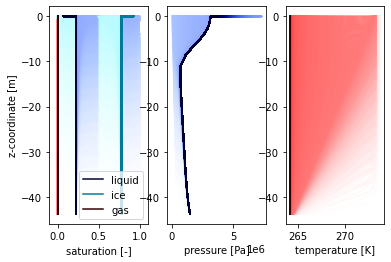

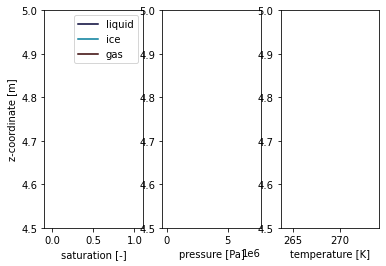

In [41]:
# plot the solution
directory = "/home/rk/ats_rk/testing/ats-demos/rk_model/01_spinup_Case1/01_spinup_Case1_obs.demo/"
#
# plot the solution
#
def plot(dirname, axs):
    """A generic plotting function that plots saturation as a function of depth."""

    plot_column_data.plot_subsurface(vis, ['pressure',], axs[0], cmap='jet')
    axs[0].set_xlabel('pressure [Pa]')
    ax.set_ylabel('z [m]')
    
    plot_column_data.plot_subsurface(vis, ['saturation_liquid',], axs[1], None, cmap='jet')
    axs[0].set_xlabel('saturation [-]')
    ax.set_ylabel('z [m]')

def plot(directory, axs, style):
    # load the data
    vis = ats_xdmf.VisFile(directory, time_unit='d')
    vis.loadMesh(columnar=True)
    dati = np.array([vis.getArray(v) for v in ["pressure", "pressure", "saturation_liquid", 
                                    "saturation_ice", "saturation_gas", "temperature"]])
    times = vis.times
    
    ice = colors.cm_mapper(-10, times[-1], colors.ice_cmap())
    water = colors.cm_mapper(-10, times[-1], colors.water_cmap())
    gas = colors.cm_mapper(-10, times[-1], colors.gas_cmap())    
    
    # plot saturation of liquid, pressure
    z = vis.centroids[:,2]
    for i,t in enumerate(times):
        label = False
        if i == len(times)-1:
            axs[0].plot(dati[2,i,:],z, style, color=water(t), label='liquid')
            axs[0].plot(dati[3,i,:],z, style, color=ice(t), label='ice')
            axs[0].plot(dati[4,i,:],z, style, color=gas(t), label='gas')
        else:
            axs[0].plot(dati[2,i,:],z, style, color=water(t))
            axs[0].plot(dati[3,i,:],z, style, color=ice(t))
            axs[0].plot(dati[4,i,:],z, style, color=gas(t))
        axs[2].plot(dati[5,i,:],z, style, color=gas(t))
        axs[1].plot(dati[1,i,:],z, style, color=water(t))
        axs[0].plot(dati[2,i,:],z, style, color=water(t))
        axs[0].plot(dati[3,i,:],z, style, color=ice(t))
        axs[0].plot(dati[4,i,:],z, style, color=gas(t))

def decorate(axs):
    axs[0].set_xlabel('saturation [-]')
    axs[0].set_ylabel('z-coordinate [m]')
    axs[1].set_xlabel('pressure [Pa]')
    axs[2].set_xlabel('temperature [K]')
    axs[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axs[0].set_xlim([-.1,1.1])
    axs[0].legend()


# full column
fig, axs = plt.subplots(1,3)
plot(directory, axs, '-')
decorate(axs)

# and a zoomed version
fig, axs = plt.subplots(1,3)
plot(directory, axs, '-')
decorate(axs)
axs[0].set_ylim([4.5,5])
axs[1].set_ylim([4.5,5])
axs[2].set_ylim([4.5,5])


plt.show()
            

In [44]:
file_name = '/home/rk/ats_rk/testing/ats-demos/rk_model/01_spinup_Case1/01_spinup_Case1_obs.demo/'
input_filename = '/home/rk/ats_rk/testing/ats-demos/rk_model/Xml_input/01_spinup_Case1/01_spinup_Case1.xml'

In [45]:
# load the ATS solution
directory = f"{file_name}"
vis = ats_xdmf.VisFile(directory)
vis.loadMesh(columnar=True)

In [46]:
directory

'/home/rk/ats_rk/testing/ats-demos/rk_model/01_spinup_Case1/01_spinup_Case1_obs.demo/'

### RK - work

In [47]:
### Extracting the subsurface data
with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    porosity = hdf.get('base_porosity.cell.0')
    print(porosity)

List of datasets in this file: 
 
 ['base_porosity.cell.0', 'capillary_pressure_gas_liq.cell.0', 'capillary_pressure_liq_ice.cell.0', 'cell_volume.cell.0', 'darcy_velocity.cell.0', 'darcy_velocity.cell.1', 'darcy_velocity.cell.2', 'density_rock.cell.0', 'dwater_content|dtemperature.cell.0', 'energy.cell.0', 'enthalpy.cell.0', 'enthalpy_times_relative_permeability.cell.0', 'internal_energy_ice.cell.0', 'internal_energy_liquid.cell.0', 'internal_energy_rock.cell.0', 'mass_density_liquid.cell.0', 'molar_density_ice.cell.0', 'molar_density_liquid.cell.0', 'permeability.cell.0', 'porosity.cell.0', 'pressure.cell.0', 'relative_permeability.cell.0', 'saturation_gas.cell.0', 'saturation_ice.cell.0', 'saturation_liquid.cell.0', 'temperature.cell.0', 'thermal_conductivity.cell.0', 'viscosity_liquid.cell.0', 'water_content.cell.0']


<HDF5 group "/base_porosity.cell.0" (1827 members)>


### Recreating the node information of the cells:
- The centroidal distance was calculated while generating the ats mesh - ../ats/tools/meshing_ats_rk/hillslope_example_new.ipynb

In [48]:
# Inserting a '0' at the 0th position (to find rolling mean later)
#layerDepth = np.insert(layer_depth,0,0)
# To find the rolling mean:
# https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-scipy
#def moving_average(x, w):
    #return np.convolve(x, np.ones(w), 'valid') / w

#layer_depth_center = moving_average(layer_depth_center,2)
#print(layer_depth_center)

In [49]:
dz_hillslope = pd.read_csv('/home/rk/ats_rk/testing/ats-demos/rk_model/Data/layerdepthcentroid_hillslope.csv')
dz = dz_hillslope['layer_depth']
len(dz)

27

In [50]:
# The following data 'layerdepthcentroid_hillslope.csv' was extracted from the meshing files
dz_hillslope = pd.read_csv('/home/rk/ats_rk/testing/ats-demos/rk_model/Data/layerdepthcentroid_hillslope.csv')
z = dz_hillslope['layer_depth']


# Adding a bunch of cells to reach 45 m with 40 cells

dz = 1.4
i = len(z)
total_depth = z[26]
while total_depth < 45:
    z[i] = z[i - 1] + dz
    total_depth += dz
    i += 1
z.head()    

0    0.006000
1    0.019200
2    0.035040
3    0.054048
4    0.076858
Name: layer_depth, dtype: float64

In [51]:
z = -z
print(z.head())

0   -0.006000
1   -0.019200
2   -0.035040
3   -0.054048
4   -0.076858
Name: layer_depth, dtype: float64


In [52]:
def inputfiles_pddataframes(file_name,t):
    """
    The function is defined to read the input files from the ats simulation. 
    For each time instance, a dataframe can store the data.
 
    Parameters
    ------
    
    Input parameters:
    
    file_name : Provide the path to access the file name. 
    Ex: 'richards_steadystate.demo/ats_vis_data.h5'
    
    t : The time instance at which the data is required.
    Ex: cell_volume.cell.0/{t} - here 0/0 - signifies the first directory (with data at t=0), 
    similarly 0/1 - signifies the second directory (with data at t=1).
            
    Output parameters:
    
    data_results : pandas dataframe with all the key elements of the simulation.
    
    - idea - can't we write a smart function that directly accesses all the columns? - !
    
    """
    # The following data 'layerdepthcentroid_hillslope.csv' was extracted from the meshing files
    dz_hillslope = pd.read_csv('/home/rk/ats_rk/testing/ats-demos/rk_model/Data/layerdepthcentroid_hillslope.csv')
    z = dz_hillslope['layer_depth']

    # Adding a bunch of cells to reach 45 m with 40 cells
    dz = 1.4
    i = len(z)
    total_depth = z[26]
    while total_depth < 45:
        z[i] = z[i - 1] + dz
        total_depth += dz
        i += 1
    z = -z
    
    with h5py.File(file_name,'r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0/{t}'))
        cell_volume = cell_volume_all.flatten()
        
        
        # Storing the variables/constants in a dataframe - Do we have a direct function to do this? 
        # Can we simplify the code?
        
        data_results = pd.DataFrame(index=z,data=cell_volume,columns=['cell_volume'])

        mass_density_all = np.array(hdf.get(f'mass_density_liquid.cell.0/{t}'))
        mass_density = mass_density_all.flatten()
        data_results['mass_density [rho_l] [kg m^{-3}]'] = mass_density



        molar_density_all = np.array(hdf.get(f'molar_density_liquid.cell.0/{t}'))
        molar_density = molar_density_all.flatten()
        data_results['molar_density [n_l] [mol m^{-3}]'] = molar_density


        permeability_all = np.array(hdf.get(f'permeability.cell.0/{t}'))
        permeability = permeability_all.flatten()
        data_results['Absolute permeability [K] (m^{2})'] = permeability



        porosity_all = np.array(hdf.get(f'porosity.cell.0/{t}'))
        porosity = porosity_all.flatten()
        data_results['Porosity [phi] (-)'] = porosity

        pressure_all = np.array(hdf.get(f'pressure.cell.0/{t}'))
        pressure = pressure_all.flatten()
        data_results['Abs pressure [p_abs] [Pa]'] = pressure 
        # Water pressure or total pressure (Atm + water)? - Probably both

        relative_permeability_all = np.array(hdf.get(f'relative_permeability.cell.0/{t}'))
        relative_permeability = relative_permeability_all.flatten()
        data_results['Relative permeability [kr] [-]'] = relative_permeability


        saturation_gas_all = np.array(hdf.get(f'saturation_gas.cell.0/{t}'))
        saturation_gas = saturation_gas_all.flatten()
        data_results['Saturation of gas [s_g] [-]'] = saturation_gas


        saturation_liquid_all = np.array(hdf.get(f'saturation_liquid.cell.0/{t}'))
        saturation_liquid = saturation_liquid_all.flatten()
        data_results['Saturation of liquid [s_l] [-]'] = saturation_liquid


        
        saturation_ice_all = np.array(hdf.get(f'saturation_ice.cell.0/{t}'))
        saturation_ice = saturation_ice_all.flatten()
        data_results['Saturation of ice [s_i] [-]'] = saturation_ice
        
        temperature_all = np.array(hdf.get(f'temperature.cell.0/{t}'))
        temperature = temperature_all.flatten()
        data_results['Temperature [T] [K]'] = temperature


        viscosity_liquid_all = np.array(hdf.get(f'viscosity_liquid.cell.0/{t}'))
        viscosity_liquid = viscosity_liquid_all.flatten()
        data_results['viscosity_liquid [v] Pas]'] = viscosity_liquid


        water_content_all = np.array(hdf.get(f'water_content.cell.0/{t}'))
        water_content = water_content_all.flatten()
        data_results['water_content [theta] mols'] = water_content
        
        return data_results

In [53]:
# Determining the time instances at which the data is stored

with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        print(time_period)
        # Time series stored in an irregular format! - 
        # ['0' '100' '103' '104' '105' '106' '107' '108' '109' '110' '111']

[    0   100  1000 ... 99700 99800 99900]


### Storing the data for all time instances

In [54]:
for i in time_period:
    # https://stackoverflow.com/questions/1060090/changing-variable-names-with-python-for-loops
    locals()["data_results_"+str(i)] = inputfiles_pddataframes(file_name=f'{file_name}/ats_vis_data.h5', t=i)

In [57]:
len(time_period)

1827

### Plotting the initial pressure:

In [58]:
data_results_0['Abs pressure [p_abs] [Pa]'].head()

layer_depth
-0.006000   -6489.310100
-0.019200   -6359.862320
-0.035040   -6204.524984
-0.054048   -6018.120181
-0.076858   -5794.434417
Name: Abs pressure [p_abs] [Pa], dtype: float64

In [59]:
rho_avg = 1000 # kg m^{-3} - Provided by the developer 
g = 9.8006 # ms^{-2} - Provided by the user, g = (0,0,-9.8006m ms^{-2})
p_0 = 101325 # Pa

# Calculating the water pressure = p_abs -p_0
data_results_0['Water pressure [p_l] [Pa]'] = data_results_0['Abs pressure [p_abs] [Pa]'] - p_0

data_results_0['Pressure head [m]'] = data_results_0['Water pressure [p_l] [Pa]']/(rho_avg*g)

data_results_0['Elevation head [m]'] = data_results_0.index

data_results_0['Hydraulic head [m]'] = data_results_0['Pressure head [m]'] + data_results_0['Elevation head [m]']

data_results_0['Atmospheric pressure head [m]'] = 101325/(rho_avg*g)

data_results_0.head()

,cell_volume,mass_density [rho_l] [kg m^{-3}],molar_density [n_l] [mol m^{-3}],Absolute permeability [K] (m^{2}),Porosity [phi] (-),Abs pressure [p_abs] [Pa],Relative permeability [kr] [-],Saturation of gas [s_g] [-],Saturation of liquid [s_l] [-],Saturation of ice [s_i] [-],Temperature [T] [K],viscosity_liquid [v] Pas],water_content [theta] mols,Water pressure [p_l] [Pa],Pressure head [m],Elevation head [m],Hydraulic head [m],Atmospheric pressure head [m]
layer_depth,,,,,,,,,,,,,,,,,,
-0.006000,0.012000,999.933993,55504.709505,5.000000e-11,0.85,-6489.310100,0.000002,0.749597,0.250403,0.0,273.65,0.001753,141.765391,-107814.310100,-11.000787,-0.006000,-11.006787,10.338653
-0.019200,0.014400,999.933993,55504.709505,5.000000e-11,0.85,-6359.862320,0.000002,0.749503,0.250497,0.0,273.65,0.001753,170.182026,-107684.862320,-10.987579,-0.019200,-11.006779,10.338653
-0.035040,0.017280,999.933993,55504.709505,5.000000e-11,0.85,-6204.524984,0.000002,0.749391,0.250609,0.0,273.65,0.001753,204.310121,-107529.524984,-10.971729,-0.035040,-11.006769,10.338653
-0.054048,0.020736,999.933993,55504.709505,2.000000e-13,0.50,-6018.120181,0.020272,0.333413,0.666587,0.0,273.65,0.001753,383.602509,-107343.120181,-10.952709,-0.054048,-11.006757,10.338653
-0.076858,0.024883,999.933993,55504.709505,2.000000e-13,0.50,-5794.434417,0.020394,0.332979,0.667021,0.0,273.65,0.001753,460.623130,-107119.434417,-10.929885,-0.076858,-11.006743,10.338653


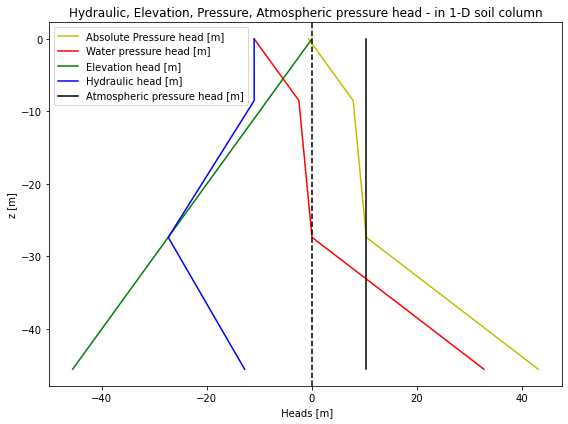

In [60]:
# To find the elevation where -ve pressure head begins
#z_drop = data_results_0[data_results_0['Pressure head [m]'].le(0)].index[0]

z = data_results_0.index

fig = plt.figure(figsize=(8,6))

plt.title('Hydraulic, Elevation, Pressure, Atmospheric pressure head - in 1-D soil column')
plt.plot(data_results_0['Abs pressure [p_abs] [Pa]']/(rho_avg*g), z, 'y', label='Absolute Pressure head [m]')
plt.plot(data_results_0['Pressure head [m]'], z, 'r', label='Water pressure head [m]')
plt.plot(data_results_0['Elevation head [m]'], z, 'g', label='Elevation head [m]')
plt.plot(data_results_0['Hydraulic head [m]'], z, 'b', label='Hydraulic head [m]')
plt.plot(data_results_0['Atmospheric pressure head [m]'], z, 'k', label='Atmospheric pressure head [m]')
plt.axvline(x=0,color='k',linestyle='--')
plt.ylabel('z [m]')
plt.xlabel(' Heads [m]')
plt.legend()
plt.tight_layout()
plt.show()

In [61]:
data_results_0.columns

Index(['cell_volume', 'mass_density [rho_l] [kg m^{-3}]',
       'molar_density [n_l] [mol m^{-3}]', 'Absolute permeability [K] (m^{2})',
       'Porosity [phi] (-)', 'Abs pressure [p_abs] [Pa]',
       'Relative permeability [kr] [-]', 'Saturation of gas [s_g] [-]',
       'Saturation of liquid [s_l] [-]', 'Saturation of ice [s_i] [-]',
       'Temperature [T] [K]', 'viscosity_liquid [v] Pas]',
       'water_content [theta] mols', 'Water pressure [p_l] [Pa]',
       'Pressure head [m]', 'Elevation head [m]', 'Hydraulic head [m]',
       'Atmospheric pressure head [m]'],
      dtype='object')

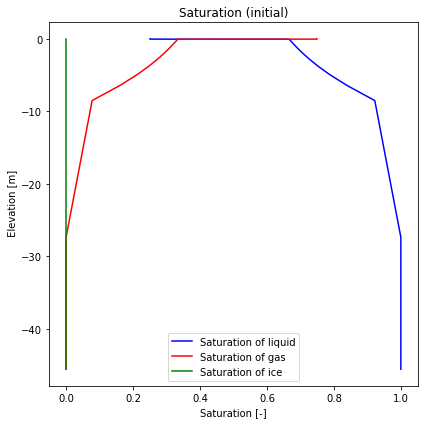

In [62]:
fig = plt.figure(figsize=(6,6))

plt.title('Saturation (initial)')
plt.plot(data_results_0['Saturation of liquid [s_l] [-]'], z, 'b', label='Saturation of liquid')
plt.plot(data_results_0['Saturation of gas [s_g] [-]'], z, 'r', label='Saturation of gas')
plt.plot(data_results_0['Saturation of ice [s_i] [-]'], z, 'g', label='Saturation of ice')

plt.xlabel('Saturation [-]')
plt.ylabel(' Elevation [m]')
plt.tight_layout()
plt.legend()
#plt.show()

In [63]:
data_results_0.columns

Index(['cell_volume', 'mass_density [rho_l] [kg m^{-3}]',
       'molar_density [n_l] [mol m^{-3}]', 'Absolute permeability [K] (m^{2})',
       'Porosity [phi] (-)', 'Abs pressure [p_abs] [Pa]',
       'Relative permeability [kr] [-]', 'Saturation of gas [s_g] [-]',
       'Saturation of liquid [s_l] [-]', 'Saturation of ice [s_i] [-]',
       'Temperature [T] [K]', 'viscosity_liquid [v] Pas]',
       'water_content [theta] mols', 'Water pressure [p_l] [Pa]',
       'Pressure head [m]', 'Elevation head [m]', 'Hydraulic head [m]',
       'Atmospheric pressure head [m]'],
      dtype='object')

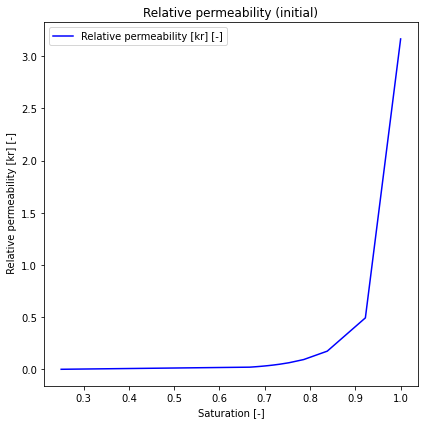

In [64]:
fig = plt.figure(figsize=(6,6))

plt.title('Relative permeability (initial)')
plt.plot(data_results_0['Saturation of liquid [s_l] [-]'],data_results_0['Relative permeability [kr] [-]'], 'b', label='Relative permeability [kr] [-]')

plt.xlabel('Saturation [-]')
plt.ylabel(' Relative permeability [kr] [-]')
plt.tight_layout()
plt.legend()
#plt.show()

In [65]:
with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
        print(time_period)

[     0    100    200 ... 182400 182500 182600]


In [66]:
len(time_period)

1827

In [67]:
time_period[1:]

array([   100,    200,    300, ..., 182400, 182500, 182600])

### Defining a dataframe that extracts the data for a single variable for all time instances

In [68]:
def input_datavar(file_name, variable):
    """
    The function defined to extract a variable across all time instances.
    
    Parameters
    ------
    
    Input parameters:
    
    file_name : Provide the path to access the file name. 
    Ex: 'richards_steadystate.demo/ats_vis_data.h5'
    
    variable: Name of the variable in the dataset that you are interested in.
    Ex: 'cell_volume'
    
    Output parameters:
    
    data_var : pandas dataframe with the time series data of the variable.
    
    """
    
    # Storing the dz coordinates
    ### Finding the average between two rows - to find centroidal distance

    # The following data 'layerdepthcentroid_hillslope.csv' was extracted from the meshing files
    dz_hillslope = pd.read_csv('/home/rk/ats_rk/testing/ats-demos/rk_model/Data/layerdepthcentroid_hillslope.csv')
    z = dz_hillslope['layer_depth']

    # Adding a bunch of cells to reach 45 m with 40 cells
    dz = 1.4
    i = len(z)
    total_depth = z[26]
    while total_depth < 45:
        z[i] = z[i - 1] + dz
        total_depth += dz
        i += 1
    
    # Since we are going vertically downwards
    z = -z
    
    # To determine the time period and the list in which the dataframes 
    
    with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
    
    with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        var_all_0 = np.array(hdf.get(f'{variable}.cell.0/0'))
        var_0 = var_all_0.flatten()
        data_var = pd.DataFrame(index=z,data=var_0,columns=[f'0'])
        
        for i in time_period[1:]:
            var_all = np.array(hdf.get(f'{variable}.cell.0/{i}'))
            var = var_all.flatten()
            
            data_var[f'{i}'] = var
    
    return data_var

In [69]:
with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    porosity = hdf.get('saturation_liquid.cell.0/100')
    print(porosity)

List of datasets in this file: 
 
 ['base_porosity.cell.0', 'capillary_pressure_gas_liq.cell.0', 'capillary_pressure_liq_ice.cell.0', 'cell_volume.cell.0', 'darcy_velocity.cell.0', 'darcy_velocity.cell.1', 'darcy_velocity.cell.2', 'density_rock.cell.0', 'dwater_content|dtemperature.cell.0', 'energy.cell.0', 'enthalpy.cell.0', 'enthalpy_times_relative_permeability.cell.0', 'internal_energy_ice.cell.0', 'internal_energy_liquid.cell.0', 'internal_energy_rock.cell.0', 'mass_density_liquid.cell.0', 'molar_density_ice.cell.0', 'molar_density_liquid.cell.0', 'permeability.cell.0', 'porosity.cell.0', 'pressure.cell.0', 'relative_permeability.cell.0', 'saturation_gas.cell.0', 'saturation_ice.cell.0', 'saturation_liquid.cell.0', 'temperature.cell.0', 'thermal_conductivity.cell.0', 'viscosity_liquid.cell.0', 'water_content.cell.0']


<HDF5 dataset "100": shape (40, 1), type "<f8">


In [70]:
### Accessing the variable at all time instances

### Add or remove variable name if required
variables = ['saturation_liquid','saturation_ice','saturation_gas','pressure','relative_permeability','temperature']

for i in variables:
    locals()["df_"+str(i)] = input_datavar(file_name, i)
    len_rows = len(locals()["df_"+str(i)].columns)
    locals()["df_"+str(i)].columns = np.arange(0,len_rows,1)

In [71]:
df_pressure.head()

,0,1,2,3,4,5,6,7,8,9,...,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826
layer_depth,,,,,,,,,,,,,,,,,,,,,
-0.006000,-6489.310100,-6477.965042,-6158.053464,-5275.998994,-3661.394673,-2854.459634,-1837.581722,-649.526816,374.989112,666.542037,...,3.721781e+06,3.720999e+06,3.720218e+06,3.719438e+06,3.718660e+06,3.717882e+06,3.717105e+06,3.716330e+06,3.715555e+06,3.714782e+06
-0.019200,-6359.862320,-6348.498742,-6028.411491,-5146.130948,-3531.357898,-2724.787605,-1707.756290,-519.699569,504.640618,796.047555,...,3.721141e+06,3.720360e+06,3.719580e+06,3.718801e+06,3.718023e+06,3.717247e+06,3.716471e+06,3.715697e+06,3.714923e+06,3.714151e+06
-0.035040,-6204.524984,-6193.100366,-5872.550900,-4989.675562,-3374.459066,-2568.847926,-1551.413257,-363.351826,660.525901,951.549045,...,3.719265e+06,3.718486e+06,3.717709e+06,3.716933e+06,3.716158e+06,3.715385e+06,3.714612e+06,3.713840e+06,3.713070e+06,3.712300e+06
-0.054048,-6018.120181,-6006.704684,-5686.139814,-4803.250304,-3188.025125,-2382.434653,-1364.990353,-176.929077,846.937819,1137.948835,...,3.168517e+06,3.168509e+06,3.168501e+06,3.168493e+06,3.168485e+06,3.168478e+06,3.168470e+06,3.168462e+06,3.168454e+06,3.168447e+06
-0.076858,-5794.434417,-5783.027217,-5462.420648,-4579.477635,-2964.212752,-2158.708388,-1141.227900,46.833773,1070.659052,1361.635578,...,3.167478e+06,3.167472e+06,3.167466e+06,3.167459e+06,3.167453e+06,3.167446e+06,3.167440e+06,3.167433e+06,3.167427e+06,3.167421e+06


In [72]:
pressure_head_data = df_pressure/(10000)

In [73]:
pressure_head_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826
layer_depth,,,,,,,,,,,,,,,,,,,,,
-0.006000,-0.648931,-0.647797,-0.615805,-0.527600,-0.366139,-0.285446,-0.183758,-0.064953,0.037499,0.066654,...,372.178132,372.099926,372.021828,371.943840,371.865960,371.788190,371.710528,371.632975,371.555530,371.478193
-0.019200,-0.635986,-0.634850,-0.602841,-0.514613,-0.353136,-0.272479,-0.170776,-0.051970,0.050464,0.079605,...,372.114071,372.035972,371.957982,371.880101,371.802329,371.724666,371.647111,371.569664,371.492326,371.415096
-0.035040,-0.620452,-0.619310,-0.587255,-0.498968,-0.337446,-0.256885,-0.155141,-0.036335,0.066053,0.095155,...,371.926455,371.848640,371.770933,371.693336,371.615846,371.538466,371.461193,371.384028,371.306971,371.230021
-0.054048,-0.601812,-0.600670,-0.568614,-0.480325,-0.318803,-0.238243,-0.136499,-0.017693,0.084694,0.113795,...,316.851670,316.850890,316.850109,316.849329,316.848549,316.847769,316.846990,316.846210,316.845431,316.844652
-0.076858,-0.579443,-0.578303,-0.546242,-0.457948,-0.296421,-0.215871,-0.114123,0.004683,0.107066,0.136164,...,316.747835,316.747193,316.746551,316.745908,316.745266,316.744624,316.743982,316.743339,316.742697,316.742055


Text(0.5, 0, 'Saturation (-)')

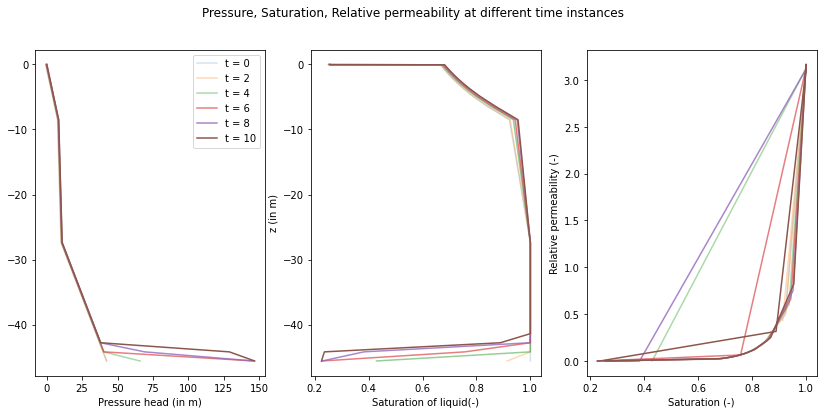

In [74]:
fig, (ax2, ax1, ax3) = plt.subplots(1, 3)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure, Saturation, Relative permeability at different time instances')

z = df_saturation_liquid.index

ax1.plot(df_saturation_liquid[0], z, alpha=0.2)
ax1.plot(df_saturation_liquid[2], z, alpha=0.3)
ax1.plot(df_saturation_liquid[4], z, alpha=0.5)
ax1.plot(df_saturation_liquid[6], z, alpha=0.6)
ax1.plot(df_saturation_liquid[8], z, alpha=0.8)
ax1.plot(df_saturation_liquid[10], z, alpha=1)
#ax1.plot(df_saturation_liquid[200], z, alpha=1)
#ax1.legend()
ax1.set_ylabel('z (in m)')
ax1.set_xlabel('Saturation of liquid(-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2, label ='t = 0')
ax2.plot(pressure_head_data[2], z, alpha=0.3, label ='t = 2')
ax2.plot(pressure_head_data[4], z, alpha=0.4, label ='t = 4')
ax2.plot(pressure_head_data[6], z, alpha=0.6, label ='t = 6')
ax2.plot(pressure_head_data[8], z, alpha=0.8, label ='t = 8')
ax2.plot(pressure_head_data[10], z, alpha=1, label ='t = 10')
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
ax2.legend()

ax3.plot(df_saturation_liquid[0], df_relative_permeability[0], alpha=0.2)
ax3.plot(df_saturation_liquid[2], df_relative_permeability[2], alpha=0.3)
ax3.plot(df_saturation_liquid[4], df_relative_permeability[4], alpha=0.4)
ax3.plot(df_saturation_liquid[6], df_relative_permeability[6], alpha=0.6)
ax3.plot(df_saturation_liquid[8], df_relative_permeability[8], alpha=0.8)
ax3.plot(df_saturation_liquid[10], df_relative_permeability[10], alpha=1)
#ax3.plot(df_saturation_liquid[200], df_relative_permeability[200], alpha=1, label ='t = 2 days')
#ax3.legend()
ax3.set_ylabel('Relative permeability (-)')
ax3.set_xlabel('Saturation (-)')


Text(0.5, 0, 'Saturation (-)')

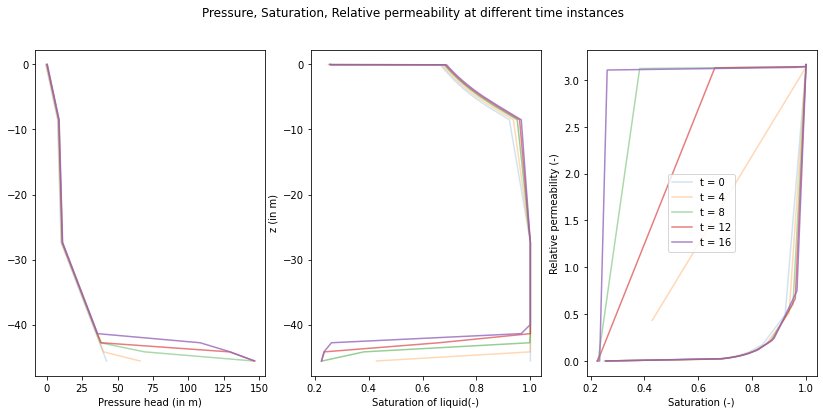

In [75]:
fig, (ax2, ax1, ax3) = plt.subplots(1, 3)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure, Saturation, Relative permeability at different time instances')

z = df_saturation_liquid.index

ax1.plot(df_saturation_liquid[0], z, alpha=0.2)
ax1.plot(df_saturation_liquid[4], z, alpha=0.3)
ax1.plot(df_saturation_liquid[8], z, alpha=0.5)
ax1.plot(df_saturation_liquid[12], z, alpha=0.6)
ax1.plot(df_saturation_liquid[16], z, alpha=0.8)
#ax1.plot(df_saturation_liquid[19], z, alpha=1)
#ax1.plot(df_saturation_liquid[200], z, alpha=1)
#ax1.legend()
ax1.set_ylabel('z (in m)')
ax1.set_xlabel('Saturation of liquid(-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2)
ax2.plot(pressure_head_data[4], z, alpha=0.3)
ax2.plot(pressure_head_data[8], z, alpha=0.4)
ax2.plot(pressure_head_data[12], z, alpha=0.6)
ax2.plot(pressure_head_data[16], z, alpha=0.8)
#ax2.plot(pressure_head_data[19], z, alpha=1)
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
#ax2.legend()

ax3.plot(df_saturation_liquid[0], df_relative_permeability[0], alpha=0.2, label ='t = 0')
ax3.plot(df_saturation_liquid[4], df_relative_permeability[2], alpha=0.3, label ='t = 4')
ax3.plot(df_saturation_liquid[8], df_relative_permeability[4], alpha=0.4, label ='t = 8')
ax3.plot(df_saturation_liquid[12], df_relative_permeability[6], alpha=0.6, label ='t = 12')
ax3.plot(df_saturation_liquid[16], df_relative_permeability[8], alpha=0.8, label ='t = 16')
#ax3.plot(df_saturation_liquid[19], df_relative_permeability[10], alpha=1, label ='t = 20')
#ax3.plot(df_saturation_liquid[200], df_relative_permeability[200], alpha=1, label ='t = 2 days')
ax3.legend()
ax3.set_ylabel('Relative permeability (-)')
ax3.set_xlabel('Saturation (-)')

Text(0.5, 0, 'Temperature (K)')

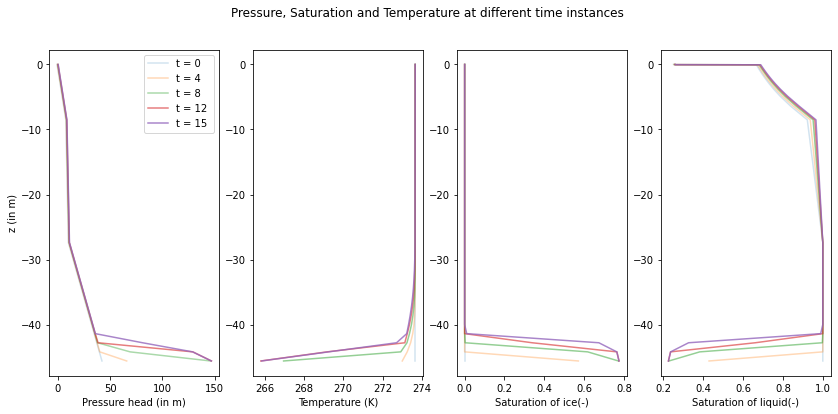

In [76]:
fig, (ax2, ax4, ax3,ax1) = plt.subplots(1, 4)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure, Saturation and Temperature at different time instances')

z = df_saturation_liquid.index

#df_saturation_liquid = df_saturation_liquid.iloc[::-1]

ax1.plot(df_saturation_liquid[0], z, alpha=0.2)
ax1.plot(df_saturation_liquid[4], z, alpha=0.3)
ax1.plot(df_saturation_liquid[8], z, alpha=0.5)
ax1.plot(df_saturation_liquid[12], z, alpha=0.6)
ax1.plot(df_saturation_liquid[15], z, alpha=0.8)
#ax1.plot(df_saturation_liquid[19], z, alpha=1)
#ax1.plot(df_saturation_liquid[200], z, alpha=1)
#ax1.legend()

ax1.set_xlabel('Saturation of liquid(-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2, label ='t = 0')
ax2.plot(pressure_head_data[4], z, alpha=0.3, label ='t = 4 ')
ax2.plot(pressure_head_data[8], z, alpha=0.4, label ='t = 8 ')
ax2.plot(pressure_head_data[12], z, alpha=0.6, label ='t = 12 ')
ax2.plot(pressure_head_data[15], z, alpha=0.8, label ='t = 15 ')
#ax2.plot(pressure_head_data[19], z, alpha=1, label ='t = 20 ')
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
ax2.set_ylabel('z (in m)')
ax2.legend()

ax3.plot(df_saturation_ice[0], z, alpha=0.2)
ax3.plot(df_saturation_ice[4], z, alpha=0.3)
ax3.plot(df_saturation_ice[8], z, alpha=0.5)
ax3.plot(df_saturation_ice[12], z, alpha=0.6)
ax3.plot(df_saturation_ice[15], z, alpha=0.8)
#ax3.plot(df_saturation_ice[19], z, alpha=1)
#ax1.plot(df_saturation_ice[200], z, alpha=1)
#ax1.legend()
#ax3.set_ylabel('z (in m)')
ax3.set_xlabel('Saturation of ice(-)')

ax4.plot(df_temperature[0], z, alpha=0.2)
ax4.plot(df_temperature[4], z, alpha=0.3)
ax4.plot(df_temperature[8], z, alpha=0.5)
ax4.plot(df_temperature[12], z, alpha=0.6)
ax4.plot(df_temperature[15], z, alpha=0.8)
#ax4.plot(df_temperature[19], z, alpha=1)
#ax1.plot(df_temperature[200], z, alpha=1)
#ax1.legend()
#ax4.set_ylabel('z (in m)')
ax4.set_xlabel('Temperature (K)')

* Q - Why does pressure increase to a large extent when liquid freezes to ice? - Density of ice and water are 0.9167–0.9168 g/cm3 and  0.9998–0.999863 g/cm3 - Change in temperature 
* https://courses.lumenlearning.com/cheminter/chapter/phase-diagram-for-water/ - Read this link!

### Plotting the changes near the surface

(-1.0, 0.0)

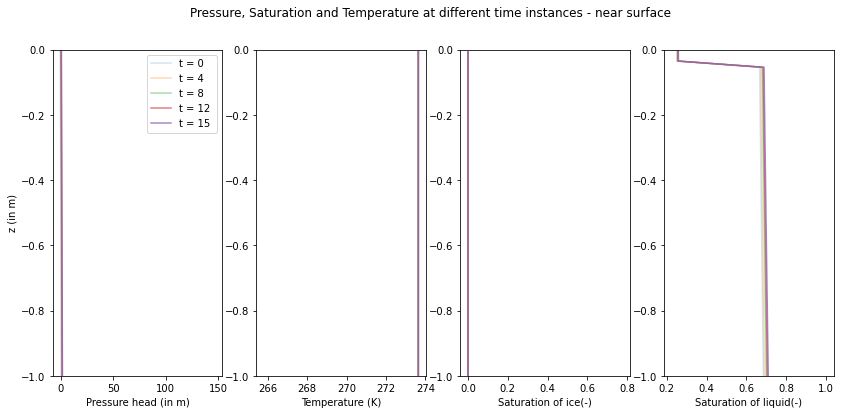

In [77]:
fig, (ax2, ax4, ax3,ax1) = plt.subplots(1, 4)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure, Saturation and Temperature at different time instances - near surface')

z = df_saturation_liquid.index

#df_saturation_liquid = df_saturation_liquid.iloc[::-1]

ax1.plot(df_saturation_liquid[0], z, alpha=0.2)
ax1.plot(df_saturation_liquid[4], z, alpha=0.3)
ax1.plot(df_saturation_liquid[8], z, alpha=0.5)
ax1.plot(df_saturation_liquid[12], z, alpha=0.6)
ax1.plot(df_saturation_liquid[15], z, alpha=0.8)
ax1.set_ylim(-1, 0)
#ax1.plot(df_saturation_liquid[19], z, alpha=1)
#ax1.plot(df_saturation_liquid[200], z, alpha=1)
#ax1.legend()

ax1.set_xlabel('Saturation of liquid(-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2, label ='t = 0')
ax2.plot(pressure_head_data[4], z, alpha=0.3, label ='t = 4 ')
ax2.plot(pressure_head_data[8], z, alpha=0.4, label ='t = 8 ')
ax2.plot(pressure_head_data[12], z, alpha=0.6, label ='t = 12 ')
ax2.plot(pressure_head_data[15], z, alpha=0.8, label ='t = 15 ')
#ax2.plot(pressure_head_data[19], z, alpha=1, label ='t = 20 ')
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
ax2.set_ylabel('z (in m)')
ax2.legend()
ax2.set_ylim(-1, 0)

ax3.plot(df_saturation_ice[0], z, alpha=0.2)
ax3.plot(df_saturation_ice[4], z, alpha=0.3)
ax3.plot(df_saturation_ice[8], z, alpha=0.5)
ax3.plot(df_saturation_ice[12], z, alpha=0.6)
ax3.plot(df_saturation_ice[15], z, alpha=0.8)
#ax3.plot(df_saturation_ice[19], z, alpha=1)
#ax1.plot(df_saturation_ice[200], z, alpha=1)
#ax1.legend()
#ax3.set_ylabel('z (in m)')
ax3.set_xlabel('Saturation of ice(-)')
ax3.set_ylim(-1, 0)

ax4.plot(df_temperature[0], z, alpha=0.2)
ax4.plot(df_temperature[4], z, alpha=0.3)
ax4.plot(df_temperature[8], z, alpha=0.5)
ax4.plot(df_temperature[12], z, alpha=0.6)
ax4.plot(df_temperature[15], z, alpha=0.8)
#ax4.plot(df_temperature[19], z, alpha=1)
#ax1.plot(df_temperature[200], z, alpha=1)
#ax1.legend()
#ax4.set_ylabel('z (in m)')
ax4.set_xlabel('Temperature (K)')
ax4.set_ylim(-1, 0)

### Preparing the dataset for initializing the conditions in hillslope:

In [78]:
### Extracting the data from the example 'column_data.h5'.  
with h5py.File(f'column_data.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    pressure_column = np.array(hdf.get('pressure'))
    print(pressure_column)
    print(np.array(hdf.get('temperature')))
    print(np.array(hdf.get('z')))

List of datasets in this file: 
 
 ['pressure', 'temperature', 'z']


[-5715161.38222217   -38288.94464055  -137009.46125349  -303729.94754876
  -604598.55774324 -1359991.77832471 -2596737.52666966 -4390081.79553017
 -5899925.38370772 -2201592.7919399   -395567.94691654  -208693.39087789
  -106984.41961357   -37649.29204946    10003.73100321    42614.18374259
    65039.79466325    80682.27302661    92311.972959     227998.28604975
   368520.8505223    425196.35995214   448699.98231278   456942.84785056
   457954.83533019   456061.82400295   453760.93426082   452489.32873421
   453140.85676651   456234.79638825   462026.32667192   470512.04506409
   481399.31851633   494122.28984047   507898.01614843   521834.60226221
   535075.99445141   546946.19192434   557048.06020229   565285.52361617
   571808.38943001   576910.11783969   580922.4326558    584140.76186134
   586791.28979156   589030.36787342   590959.58325265   592643.21104279
   594122.35191633   595428.49402298   596724.59935131

In [79]:
directory

'/home/rk/ats_rk/testing/ats-demos/rk_model/01_spinup_Case1/01_spinup_Case1_obs.demo/'

In [39]:
# Creating the input file: First creating a pandas dataframe and then converted to header file.

directory = '/home/rk/ats_rk/testing/ats-demos/rk_model/01_spinup_Case1/01_spinup_Case1_obs.demo'

### Extracting the data from the example 'column_data.h5'.  
with h5py.File(f'{directory}/ats_vis_data.h5','r') as hdf:
    ls = list(hdf.keys())
    #print('List of datasets in this file: \n \n', ls)
    #print('\n')
     
    pressure_column = np.array(hdf.get('pressure.cell.0/400'))
    temperature_column = np.array(hdf.get('temperature.cell.0/400'))

    
    #nput_data_hillslope = pd.DataFrame(index=np.arange(1,41,1),data=z,columns=['layer_depth'])
    #nput_data_hillslope['pressure'] = pressure_column
    #nput_data_hillslope['temperature'] = temperature_column
    #nput_data_hillslope.rename(columns={'layer_depth':'z'}, inplace=True)

    
#nput_data_hillslope.to_hdf('IC_column_data.h5', mode='w')

In [135]:
hf_input = h5py.File('IC_column_data.h5','w')

In [136]:
hf_input.create_dataset('z',data=z)
hf_input.create_dataset('pressure',data=pressure_column)
hf_input.create_dataset('temperature',data=temperature_column)

<HDF5 dataset "temperature": shape (40, 1), type "<f8">

In [137]:
hf_input.close()

In [138]:
### Reading the file once more 
### Extracting the data from the example 'column_data.h5'.  
with h5py.File(f'IC_column_data.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    pressure_column = np.array(hdf.get('pressure'))
    print(pressure_column)
    #temperature_column = np.array(hdf.get('temperature.cell.0/1600'))

List of datasets in this file: 
 
 ['pressure', 'temperature', 'z']


[[4546195.97819994]
 [4544342.68748985]
 [4539267.41185487]
 [3120962.28793194]
 [3118463.24696783]
 [3115153.73363198]
 [3111024.35034976]
 [3106214.08384347]
 [3101021.63235692]
 [3095810.29563436]
 [3090808.22629565]
 [3085938.884721  ]
 [3080816.3932873 ]
 [3074832.63291816]
 [3067179.10730141]
 [3056768.36682855]
 [3042088.00322244]
 [3020994.47784997]
 [2990421.34719953]
 [2945952.15022392]
 [2881183.72172647]
 [2778287.57494114]
 [2599945.47377538]
 [2287306.30746996]
 [1771319.76857349]
 [1095855.57755764]
 [ 684296.438499  ]
 [ 677840.48635519]
 [ 724984.94423489]
 [ 774095.27983019]
 [ 823304.78514825]
 [ 876190.97543225]
 [ 930309.37986948]
 [ 986715.48243438]
 [1050322.89444143]
 [1106637.34744009]
 [1176165.44253812]
 [1261595.59703653]
 [1399540.31654013]
 [1544787.05247275]]


In [82]:
# Storing the input data as a dataframe
with h5py.File(f'{directory}/ats_vis_data.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    pressure_column = np.array(hdf.get('pressure.cell.0/1600'))
    temperature_column = np.array(hdf.get('temperature.cell.0/1600'))

    
    input_data_hillslope = pd.DataFrame(index=np.arange(1,41,1),data=z,columns=['layer_depth'])
    input_data_hillslope['pressure'] = pressure_column
    input_data_hillslope['temperature'] = temperature_column
    input_data_hillslope.rename(columns={'layer_depth':'z'}, inplace=True)

    


List of datasets in this file: 
 
 ['base_porosity.cell.0', 'capillary_pressure_gas_liq.cell.0', 'capillary_pressure_liq_ice.cell.0', 'cell_volume.cell.0', 'darcy_velocity.cell.0', 'darcy_velocity.cell.1', 'darcy_velocity.cell.2', 'density_rock.cell.0', 'dwater_content|dtemperature.cell.0', 'energy.cell.0', 'enthalpy.cell.0', 'enthalpy_times_relative_permeability.cell.0', 'internal_energy_ice.cell.0', 'internal_energy_liquid.cell.0', 'internal_energy_rock.cell.0', 'mass_density_liquid.cell.0', 'molar_density_ice.cell.0', 'molar_density_liquid.cell.0', 'permeability.cell.0', 'porosity.cell.0', 'pressure.cell.0', 'relative_permeability.cell.0', 'saturation_gas.cell.0', 'saturation_ice.cell.0', 'saturation_liquid.cell.0', 'temperature.cell.0', 'thermal_conductivity.cell.0', 'viscosity_liquid.cell.0', 'water_content.cell.0']




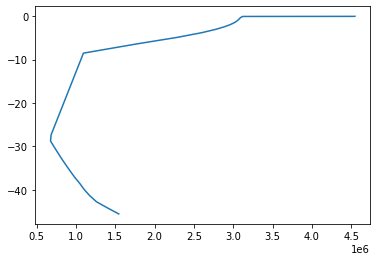

In [141]:
plt.plot(input_data_hillslope['pressure'], input_data_hillslope['z'])

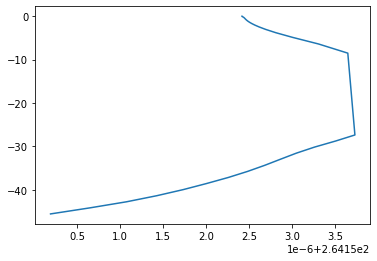

In [142]:
plt.plot(input_data_hillslope['temperature'], input_data_hillslope['z'])

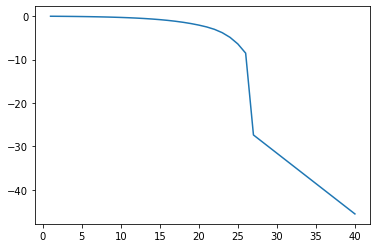

In [143]:
plt.plot(input_data_hillslope['z'])

In [80]:
directory

'/home/rk/ats_rk/testing/ats-demos/rk_model/01_spinup_Case1/01_spinup_Case1_obs.demo/'

In [81]:
### Reading the observation files:
file_observation = '/home/rk/ats_rk/testing/ats-demos/rk_model/01_spinup_Case1/01_spinup_Case1_obs.demo/observation.dat'

# https://stackoverflow.com/questions/41025416/read-data-dat-file-with-pandas
observations = pd.read

'/home/rk/ats_rk/testing/ats-demos/rk_model/01_spinup_Case1/01_spinup_Case1_obs.demo/observation.dat'